<a href="https://colab.research.google.com/github/Omega-84/ML-Capstone-Project-Regression-TedTalksViewPrediction/blob/individual/Modelling_take2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive._mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
from warnings import filterwarnings
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,LabelEncoder,PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline 
from xgboost import XGBRegressor,XGBRFRegressor
from sklearn.metrics import r2_score 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
!pip install category_encoders
from category_encoders import CatBoostEncoder,TargetEncoder
from yellowbrick.cluster import KElbowVisualizer
filterwarnings("ignore")

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Capstone 3 Regression/Varun/tmp.csv").drop('Unnamed: 0',axis=1)

In [ ]:
df.head()

,speaker_1,views,native_lang,comments,duration,no_of_lang,talk_category,event_cat,video_age
0,Al Gore,3523392,en,272.0,16.283333,43,Culture and society,ted,14
1,Hans Rosling,14501685,en,628.0,19.833333,49,International topics,ted,14
2,David Pogue,1920832,en,124.0,21.433333,26,Culture and society,ted,14
3,Majora Carter,2664069,en,219.0,18.600000,35,Climate change,ted,14
4,Sir Ken Robinson,65051954,en,4931.0,19.400000,62,Finance and economics,ted,14


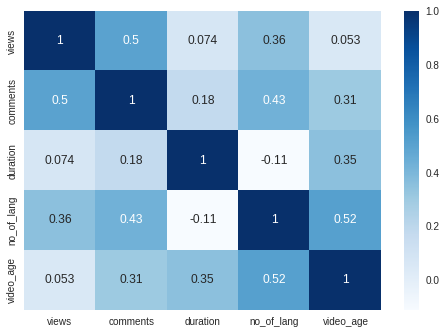

In [ ]:
sns.heatmap(df.corr(),annot=True,cmap='Blues');

In [ ]:
count_df = pd.DataFrame(df['speaker_1'].value_counts()).reset_index()
count_df['frequency'] = count_df['speaker_1']/len(df)

In [ ]:
df = df.merge(count_df,how='inner',left_on='speaker_1',right_on='index')
df

,speaker_1_x,views,native_lang,comments,duration,no_of_lang,talk_category,event_cat,video_age,index,speaker_1_y,frequency
0,Al Gore,3523392,en,272.0,16.283333,43,Culture and society,ted,14,Al Gore,4,0.000999
1,Al Gore,2187523,en,672.0,27.900000,44,International topics,ted,12,Al Gore,4,0.000999
2,Al Gore,961451,en,862.0,7.733333,47,"Science, technology and innovation",ted,11,Al Gore,4,0.000999
3,Al Gore,2090031,en,624.0,25.333333,27,International topics,ted,4,Al Gore,4,0.000999
4,Hans Rosling,14501685,en,628.0,19.833333,49,International topics,ted,14,Hans Rosling,10,0.002497
...,...,...,...,...,...,...,...,...,...,...,...,...
4000,Artūrs Miksons,112898,en,NaN,15.533333,3,Culture and society,ted-x,0,Artūrs Miksons,1,0.000250
4001,Stefan C Dombrowski,307187,en,NaN,5.766667,4,Finance and economics,ted,0,Stefan C Dombrowski,1,0.000250
4002,Dick M. Carpenter II,464414,en,9.0,12.900000,1,International topics,ted-x,0,Dick M. Carpenter II,1,0.000250
4003,Daina Ramey Berry,56582,en,NaN,4.283333,1,Social issues,ted,0,Daina Ramey Berry,1,0.000250


In [ ]:
df.drop(['speaker_1_x','index','speaker_1_y'],axis=1,inplace=True)

In [ ]:
num_cols = ['views','duration','comments','no_of_lang','video_age','frequency']

In [ ]:
for i in num_cols:
  Q1 = df[i].quantile(0.25)
  Q3 = df[i].quantile(0.75)
  IQR = Q3 - Q1

  df[i]=np.where(df[i]<(Q1 - 1.5 * IQR),df[i].quantile(0.15),np.where(df[i]>(Q3 + 1.5 * IQR),df[i].quantile(0.9),df[i]))

In [ ]:
X = df.drop('views',axis=1)
y = df['views'].apply(lambda x : np.log10(x) if x != 0 else 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
numeric_cols = ['comments','duration','no_of_lang','video_age']
ohe_cols = ['native_lang','talk_category','event_cat']

In [ ]:
def CustomSampler_IQR (X, y):
    
    features = numeric_cols
    df = X.copy()
    df['Outcome'] = y
    
    indices = [x for x in df.index]    
    out_indexlist = []
        
    for col in features:
       
        #Using nanpercentile instead of percentile because of nan values
        Q1 = np.nanpercentile(df[col], 25.)
        Q3 = np.nanpercentile(df[col], 75.)
        
        cut_off = (Q3 - Q1) * 1.5
        upper, lower = Q3 + cut_off, Q1 - cut_off
                
        outliers_index = df[col][(df[col] < lower) | (df[col] > upper)].index.tolist()
        outliers = df[col][(df[col] < lower) | (df[col] > upper)].values        
        out_indexlist.extend(outliers_index)
        
    #using set to remove duplicates
    out_indexlist = list(set(out_indexlist))
    
    clean_data = np.setdiff1d(indices,out_indexlist)

    return X.loc[clean_data], y.loc[clean_data]

In [ ]:
X_train,y_train = CustomSampler_IQR(X_train,y_train)
X_test,y_test = CustomSampler_IQR(X_test,y_test)

In [ ]:
encoder=TargetEncoder(cols=['speaker_1'])
encoded_train = encoder.fit_transform(X_train['speaker_1'],y_train).values
X_train['speaker_1'] = encoded_train 
encoded_test = encoder.transform(X_test['speaker_1'],y_test).values
X_test['speaker_1'] = encoded_test

In [ ]:
scaler = StandardScaler()
ohe = OneHotEncoder()
imputer = KNNImputer()

In [ ]:
ct = make_column_transformer((imputer,['comments']),
                             (scaler,numeric_cols ),                                                                                      
                             (ohe,ohe_cols),                           
                             remainder='passthrough',
                             )
pipe = make_pipeline(ct)

In [ ]:
X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)

In [ ]:
xgb_reg = XGBRegressor(n_jobs=-1)

In [ ]:
xgb_reg.fit(X_train,y_train)

[14:28:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_jobs=-1)

In [ ]:
r2_score(10**y_train,10**xgb_reg.predict(X_train))

0.5130866041036424

In [ ]:
r2_score(10**y_test,10**xgb_reg.predict(X_test))

0.4372990677288996

In [ ]:
from lightgbm import LGBMRegressor 

In [ ]:
lgbm = LGBMRegressor()
lgbm.fit(X_train,y_train)

ValueError: ignored